In [1]:
'''
Author: YongBai, created on 2018/6/27
'''
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt

# handle chinese characters in plot
font=matplotlib.font_manager.FontProperties(fname='/usr/share/fonts/wqy-zenhei/wqy-zenhei.ttc')
matplotlib.rcParams['axes.unicode_minus'] = False

% matplotlib inline


In [2]:
ROOT_PATH = '/home/baiyong/datasets/tongji/endometrial_cancer'

pos_pat_txt = os.path.join(ROOT_PATH,'final_pos_pats.txt')
neg_pat_txt = os.path.join(ROOT_PATH,'final_neg_pats.txt')

# final lab results used to train and test model
lab_results_txt = os.path.join(ROOT_PATH,'final_lab_results_4model.txt')

# final lab test list
lab_list_txt = os.path.join(ROOT_PATH,'final_lablists_add_0623.txt')

In [3]:
# load malignant patients, benign patients and final lab results
p_dtypes = {'pat_id':str, 
          'visit_n':np.int32,
          'brithday':str,
          'age':np.float32,
          'dx_code':np.int32,
          'init_in':np.int32,
          'icd':str,
          'dx_desc':str,
          'in_dx_desc':str,
          'in_dt':str,
          'out_dx_desc':str,
          'out_dt':str,
          'motality_dx':str,
          'out_summary':str}
pos_pat = pd.read_csv(pos_pat_txt, sep='\t', dtype = p_dtypes)
neg_pat = pd.read_csv(neg_pat_txt, sep='\t', dtype = p_dtypes)

pos_pids = np.unique(pos_pat['pat_id'])
neg_pids = np.unique(neg_pat['pat_id'])

labs = pd.read_csv(lab_results_txt, sep='\t')
print('The total number of labs:',labs.shape)

# load original lab lists
lab_list = pd.read_csv(lab_list_txt,sep='\t')
o_num_labs = lab_list.loc[lab_list['isNumeric']==1,'ReportItemCode']
o_cat_labs = lab_list.loc[lab_list['isNumeric']==0,'ReportItemCode']

The total number of labs: (1413, 66)


# Create the training dataset and test dataset

In [4]:
np.random.seed(123)
r_train = 0.8

n_pos_train = int(len(pos_pids)*r_train)
n_neg_train = int(len(neg_pids)*r_train)

pos_pid_train = np.random.choice(pos_pids, n_pos_train, replace=False)
neg_pid_train = np.random.choice(neg_pids, n_neg_train, replace=False)

pos_pid_test = set(pos_pids) - set(pos_pid_train)
neg_pid_test = set(neg_pids) - set(neg_pid_train)

lab_pos_train_o = labs[labs['PatientId'].isin(pos_pid_train)]
lab_neg_train_o = labs[labs['PatientId'].isin(neg_pid_train)]

lab_pos_test_o = labs[labs['PatientId'].isin(pos_pid_test)]
lab_neg_test_o = labs[labs['PatientId'].isin(neg_pid_test)]

print('The number of labs from malignant patients in training dataset.',lab_pos_train_o.shape)
print('The number of labs from benign patients in training dataset.',lab_neg_train_o.shape)
print('The number of labs from malignant patients in test dataset.',lab_pos_test_o.shape)
print('The number of labs from benign patients in test dataset.',lab_neg_test_o.shape)

The number of labs from malignant patients in training dataset. (196, 66)
The number of labs from benign patients in training dataset. (934, 66)
The number of labs from malignant patients in test dataset. (49, 66)
The number of labs from benign patients in test dataset. (234, 66)


In [5]:
'''
Training and test dataset processing:
normalize the numeric features, and one-hot for categorical feature
'''

num_labs_list = list(o_num_labs.astype(str).values)
cat_labs_list = list(o_cat_labs.astype(str).values) 

num_cols = ['PatientId'] + num_labs_list
cat_cols = ['PatientId'] + cat_labs_list

lab_pos_train_num = lab_pos_train_o.loc[:,lab_pos_train_o.columns.isin(num_cols)]
lab_neg_train_num = lab_neg_train_o.loc[:,lab_neg_train_o.columns.isin(num_cols)]

f_num_labs = list(lab_pos_train_num.columns.values)
f_cat_labs = set(labs.columns.values)-set(f_num_labs)
f_num_labs.remove('PatientId')

# calculate mean and std for numeric labs 
labs_all_train_o = pd.concat([lab_pos_train_o,lab_neg_train_o])
num_labs_mean = labs_all_train_o.loc[:,f_num_labs].mean()
num_labs_std = labs_all_train_o.loc[:,f_num_labs].std()

# numeric labs for training
lab_pos_train_num.loc[:,f_num_labs] = (lab_pos_train_num.loc[:,f_num_labs]-num_labs_mean)/num_labs_std
lab_neg_train_num.loc[:,f_num_labs] = (lab_neg_train_num.loc[:,f_num_labs]-num_labs_mean)/num_labs_std

# numeric labs for test
lab_pos_test_num = lab_pos_test_o.loc[:,lab_pos_test_o.columns.isin(num_cols)]
lab_neg_test_num = lab_neg_test_o.loc[:,lab_neg_test_o.columns.isin(num_cols)]
lab_pos_test_num.loc[:,f_num_labs] = (lab_pos_test_num.loc[:,f_num_labs]-num_labs_mean)/num_labs_std
lab_neg_test_num.loc[:,f_num_labs] = (lab_neg_test_num.loc[:,f_num_labs]-num_labs_mean)/num_labs_std

# one-hot code for categorical labs
labs_cat_df = labs.loc[:,f_cat_labs].astype(str)
labs_cc = pd.get_dummies(labs_cat_df, prefix=labs_cat_df.columns.values)
labs_all_cats = pd.concat([labs['PatientId'],labs_cc],axis = 1)

lab_pos_train = pd.merge(lab_pos_train_num,labs_all_cats, on='PatientId').drop('PatientId',axis = 1)
lab_pos_train_label = [1]*lab_pos_train.shape[0]
lab_neg_train = pd.merge(lab_neg_train_num,labs_all_cats, on='PatientId').drop('PatientId',axis = 1)
lab_neg_train_label = [0]*lab_neg_train.shape[0]

lab_pos_test = pd.merge(lab_pos_test_num,labs_all_cats, on='PatientId').drop('PatientId',axis = 1)
lab_pos_test_label = [1]*lab_pos_test.shape[0]
lab_neg_test = pd.merge(lab_neg_test_num,labs_all_cats, on='PatientId').drop('PatientId',axis = 1)
lab_neg_test_label = [0]*lab_neg_test.shape[0]

# random select samples from benign test dataset to be prediction anaylsis
# 
lab_neg_dsample = lab_neg_test.sample(n = lab_pos_test.shape[0], random_state = 123)
lab_neg_dsample_label = [0]*lab_neg_dsample.shape[0]

feat_list = lab_pos_train.columns.values


train_x = pd.concat([lab_pos_train,lab_neg_train]).values
train_y = lab_pos_train_label+lab_neg_train_label
test_x = pd.concat([lab_pos_test,lab_neg_test]).values
test_y = lab_pos_test_label + lab_neg_test_label

/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# Oversampling minority dataset

In [6]:
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter

tl = TomekLinks(random_state=123, n_jobs=-1)
sm = SMOTE(random_state=123, n_jobs=-1)
smt = SMOTETomek(random_state=123, smote=sm, tomek=tl)

X_res, y_res = smt.fit_sample(train_x, train_y)
print('Resampled dataset shape {}'.format(Counter(y_res)))


Resampled dataset shape Counter({1: 934, 0: 934})


# Train xgboost model

In [7]:
import xgboost as xgb # direct xgboost library
from xgboost.sklearn import XGBClassifier # sklearn wrapper   
from sklearn.model_selection import GridSearchCV   

dtrain = xgb.DMatrix(X_res, label=y_res)
dtest = xgb.DMatrix(test_x, label=test_y)

init_est = XGBClassifier(learning_rate =0.3, # this is analogue to eta, Typical: 0.01-0.2
                         n_estimators=260, # the number of iterations/trees.  
                         max_depth=5, # Typical values: 3-10 
                         min_child_weight=1,
                         gamma=0, # min_split_loss
                         subsample=0.8, # the fraction of observations to be randomly samples for each tree. 0.5-1
                         colsample_bytree=0.8, # the fraction of columns to be randomly samples for each tree. 0.5-1
                         objective= 'binary:logistic', 
                         reg_alpha = 0.01,
                         seed=123,early_stopping_rounds=50,n_jobs=-1)

In [18]:
'''
Tune hyperparameters 
'''
def xgb_train_cv(x_train, y_train, init_estimator = init_est, n_folds = 5, scoring = 'recall'):
    
    import warnings
    warnings.filterwarnings("ignore")
    
    param_groups = {
        '1':{ # 1. Tune max_depth and min_child_weight
            'max_depth': range(8,16),
            'min_child_weight':range(1,4)
        },
        '2':{ # 2. Tune gamma
            'gamma':[i/10.0 for i in range(0,5)]
        },
        '3':{ # 3. Tune subsample and colsample_bytree
            'subsample':[i/10.0 for i in range(6,10)],
            'colsample_bytree':[i/10.0 for i in range(6,10)]
        },
        '4':{ # 4. Tuning Regularization Parameters
            'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
        },
        '5': { # 5. Tuning learning rate and the number of estimators
            'learning_rate':[ .2, .1, .05, .01],
            'n_estimators': [int(x) for x in range(170,260,5)],
        }
    }
    best_param = {}
    cv_results = {}
    best_est = init_est
    
    for k, params in param_groups.items():
        xgb_cv = GridSearchCV(estimator = best_est, param_grid = params, 
                              scoring=scoring,n_jobs=-1,cv=n_folds,return_train_score=True)
        xgb_cv.fit(x_train,y_train)
        best_param[k] = xgb_cv.best_params_
        cv_results[k] = xgb_cv.cv_results_
        
        best_est = xgb_cv.best_estimator_
        best_est.get_booster().set_param(xgb_cv.best_params_)
    
    return cv_results,best_param,best_est


In [19]:
# train model based on f1_weighted metric
xgb_cv_results, best_param,best_est= xgb_train_cv(X_res, y_res,init_estimator=init_est,scoring='f1_weighted')

In [20]:
best_param

{'1': {'max_depth': 8, 'min_child_weight': 1},
 '2': {'gamma': 0.0},
 '3': {'colsample_bytree': 0.8, 'subsample': 0.7},
 '4': {'reg_alpha': 0.01},
 '5': {'learning_rate': 0.05, 'n_estimators': 225}}

In [21]:
i_xgb_res = pd.DataFrame(xgb_cv_results['5'])
i_xgb_results=i_xgb_res.loc[i_xgb_res['param_learning_rate']==0.05]

Text(0,0.5,'f1 score')

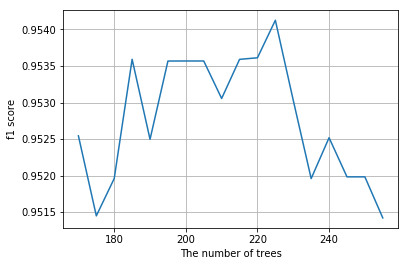

In [25]:
ax=i_xgb_results.plot(x='param_n_estimators',y='mean_test_score',legend=False, grid=True)
ax.set_xlabel('The number of trees')
ax.set_ylabel('f1 score')

In [17]:
# train model based on recall metric
xgb_cv_results_recall, best_param_recall,best_est_recall= xgb_train_cv(X_res, y_res,
                                                                       init_estimator=init_est,scoring='recall')


In [18]:
# retrain model with best parameter
best_est_recall.fit(X_res, y_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, early_stopping_rounds=50, gamma=0.0,
       learning_rate=0.05, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=123,
       silent=True, subsample=0.9)

In [19]:
'''
Prediction
'''
# from sklrean
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve,average_precision_score
from sklearn.metrics import recall_score,f1_score,classification_report,confusion_matrix
    
def perf_eval(best_model, test_x, test_y, cfm_norm=True):
    
    pred_prob_y = best_model.predict_proba(test_x)
    pred_y = best_model.predict(test_x)

    fpr, tpr, _ = roc_curve(test_y, pred_prob_y[:,1])
    auc_x = auc(fpr,tpr)
    lw = 2
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_x)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic(ROC) Curve')
    plt.legend(loc="lower right")

    ap = average_precision_score(test_y, pred_prob_y[:,1], average='weighted')

    precision, recall, thresholds = precision_recall_curve(test_y, pred_prob_y[:,1])
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format(ap))


    recall = recall_score(test_y, pred_y, average='weighted')
    f1 = f1_score(test_y, pred_y, average='weighted')
    c_rprt = classification_report(test_y, pred_y)

    cnf_matrix = confusion_matrix(test_y, pred_y)
    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['benign','malignant'], normalize=cfm_norm,
                      title='Normalized confusion matrix')

    tn, fp, fn, tp = cnf_matrix.ravel()
    print('The sensitivity is: ', tp/(tp+fn))
    print('The specificity is: ', tn/(tn+fp))
    print('The precision or positive predictive value(PPV) is:',tp/(tp+fp))
    print('The negative predictive value is: ',tn/(tn+fn))
    print('The average precision score is: ', ap)
    print('The recall score is: ', recall)
    print('The f1 score is: ', f1)
    print('The classification report is: \n', c_rprt)

Normalized confusion matrix
[[0.94 0.06]
 [0.35 0.65]]
The sensitivity is:  0.6530612244897959
The specificity is:  0.9444444444444444
The precision or positive predictive value(PPV) is: 0.7111111111111111
The negative predictive value is:  0.9285714285714286
The average precision score is:  0.7642839649355561
The recall score is:  0.8939929328621908
The f1 score is:  0.8921866458364925
The classification report is: 
              precision    recall  f1-score   support

          0       0.93      0.94      0.94       234
          1       0.71      0.65      0.68        49

avg / total       0.89      0.89      0.89       283



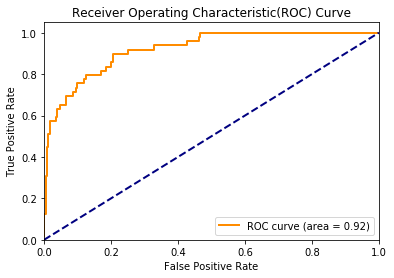

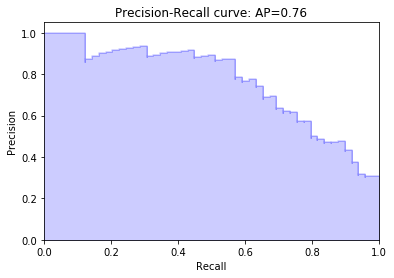

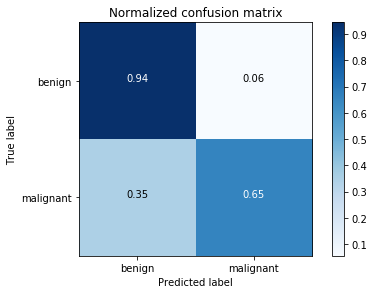

In [21]:
perf_eval(best_est_recall, test_x, test_y, cfm_norm=True)

In [22]:
def decode_feature(feat_list, lab_list):
    feat_names = []
    for feat_code in feat_list:
        f_split = feat_code.split('_')
        feat_n = lab_list.loc[lab_list['ReportItemCode']==int(f_split[0]),'ReportItemName'].values[0]
        
        len_split = len(f_split)
        if len_split > 1:
            if f_split[1] == '0':
                feat_n = feat_n + '_' + '阴性'
            else:
                feat_n = feat_n + '_' + '阳性'
         
        feat_names.append(feat_n)
    return feat_names

In [23]:
best_est_recall.feature_importances_

array([0.01, 0.02, 0.01, 0.02, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.04,
       0.02, 0.01, 0.02, 0.03, 0.04, 0.02, 0.03, 0.01, 0.01, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.05, 0.02, 0.02, 0.01, 0.04, 0.01,
       0.02, 0.02, 0.01, 0.01, 0.03, 0.01, 0.01, 0.01, 0.04, 0.  , 0.  ,
       0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.01, 0.  ],
      dtype=float32)

In [24]:
def plot_feat_importance(best_model, lab_list, feat_list):
    
    feat_importance = best_model.feature_importances_

    indices = np.argsort(feat_importance) # increasing sorting
    feat_list_sorted = feat_list[indices]
    feat_names_sorted = decode_feature(feat_list_sorted, lab_list)

    # print the feature importance
    # for name, importance in zip(feat_list, feat_importance):
    #     print(name, "=", importance)
    plt.figure(figsize=[10,20])
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), feat_importance[indices], align='center')
    plt.yticks(range(len(indices)), feat_names_sorted, fontproperties=font,fontsize=12)
    plt.xlabel('Relative Importance')
    return feat_list_sorted,feat_names_sorted, indices

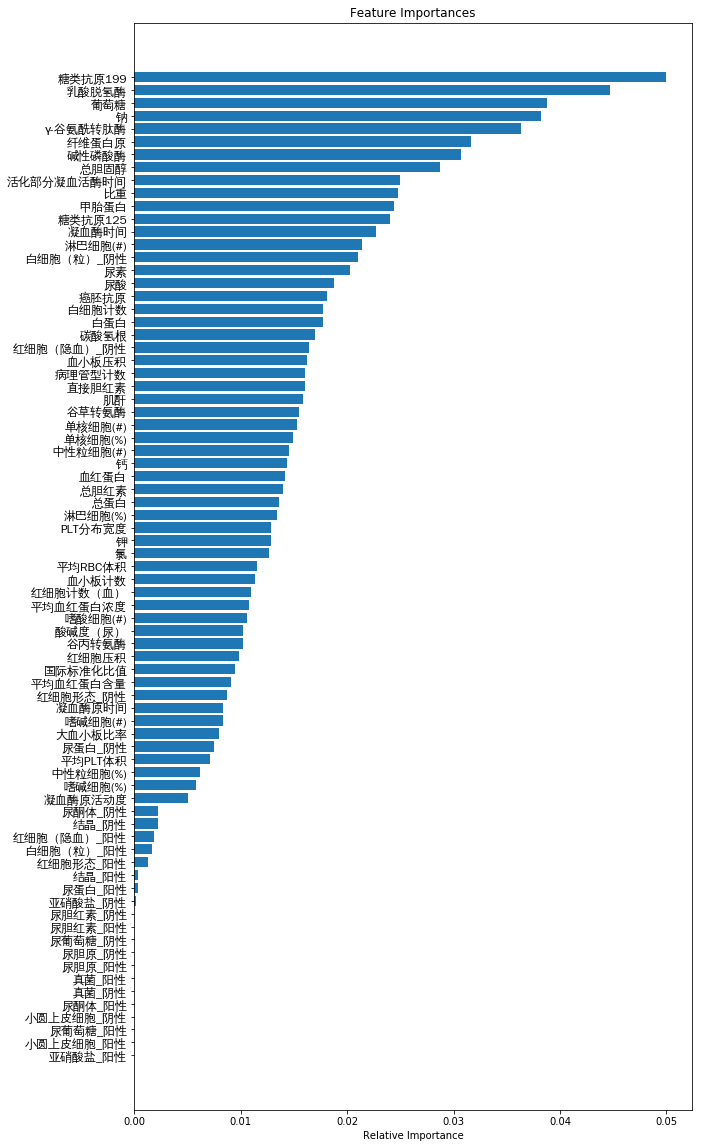

In [25]:
feat_list_sorted,feat_names_sorted,index_sorted = plot_feat_importance(best_est_recall,lab_list,feat_list)

# Retrain model with important feature

In [26]:
def creat_dataset_with_imp_feature(r_top_important_feat, feat_list_sorted,
                                  lab_pos_train,lab_neg_train,
                                  lab_pos_test,lab_neg_test):
    '''
    creat training and test dataset based on the important features
    '''
    
    n_top_labs = int(len(feat_list_sorted)*r_top_important_feat)
    top_labs_code = feat_list_sorted[::-1][:n_top_labs]

    lab_pos_train_f_sel = lab_pos_train.loc[:,lab_pos_train.columns.isin(top_labs_code)]
    lab_pos_train_label_f_sel = [1]*lab_pos_train.shape[0]
    lab_neg_train_f_sel = lab_neg_train.loc[:,lab_neg_train.columns.isin(top_labs_code)]
    lab_neg_train_label_f_sel = [0]*lab_neg_train.shape[0]

    lab_pos_test_f_sel = lab_pos_test.loc[:,lab_pos_test.columns.isin(top_labs_code)]
    lab_pos_test_label_f_sel = [1]*lab_pos_test.shape[0]
    lab_neg_test_f_sel = lab_neg_test.loc[:,lab_neg_test.columns.isin(top_labs_code)]
    lab_neg_test_label_f_sel = [0]*lab_neg_test.shape[0]

    train_x_f_sel = pd.concat([lab_pos_train_f_sel,lab_neg_train_f_sel]).values
    train_y_f_sel = lab_pos_train_label_f_sel+lab_neg_train_label_f_sel
    test_x_f_sel = pd.concat([lab_pos_test_f_sel,lab_neg_test_f_sel]).values
    test_y_f_sel = lab_pos_test_label_f_sel + lab_neg_test_label_f_sel

    # selected features
    feat_list_f_sel = lab_pos_train_f_sel.columns.values
    
    return train_x_f_sel, train_y_f_sel, test_x_f_sel,test_y_f_sel,feat_list_f_sel

# Over-/down sampling for the dataset with selected features

Normalized confusion matrix
[[0.96 0.04]
 [0.31 0.69]]
The sensitivity is:  0.6938775510204082
The specificity is:  0.9572649572649573
The precision or positive predictive value(PPV) is: 0.7727272727272727
The negative predictive value is:  0.9372384937238494
The average precision score is:  0.7623203584160279
The recall score is:  0.911660777385159
The f1 score is:  0.9097529763102518
The classification report is: 
              precision    recall  f1-score   support

          0       0.94      0.96      0.95       234
          1       0.77      0.69      0.73        49

avg / total       0.91      0.91      0.91       283



(array(['216_0', '1004_0', '736', '244', '443', '1098', '960', '289',
        '649', '1320', '362', '5541', '1177', '65', '85', '764', '100',
        '245', '1407', '1190', '626', '1359', '130', '1357', '741', '612',
        '1000', '355', '146', '105', '1181', '683', '1107', '269', '1062',
        '1063', '1204', '488', '1050', '448', '1049', '1270', '1078',
        '789', '1184', '1077'], dtype=object),
 ['红细胞（隐血）_阴性',
  '白细胞（粒）_阴性',
  '凝血酶时间',
  '钙',
  '碳酸氢根',
  '钠',
  '钾',
  '纤维蛋白原',
  '肌酐',
  '比重',
  '葡萄糖',
  '糖类抗原199',
  '病理管型计数',
  '甲胎蛋白',
  '白蛋白',
  '尿素',
  '碱性磷酸酶',
  '糖类抗原125',
  '总蛋白',
  '酸碱度（尿）',
  '氯',
  '总胆固醇',
  '活化部分凝血活酶时间',
  '总胆红素',
  '尿酸',
  '癌胚抗原',
  '乳酸脱氢酶',
  'γ-谷氨酰转肽酶',
  '谷草转氨酶',
  '谷丙转氨酶',
  '血小板压积',
  '直接胆红素',
  '中性粒细胞(#)',
  '嗜酸细胞(#)',
  '平均血红蛋白浓度',
  '平均RBC体积',
  '血小板计数',
  '血红蛋白',
  '淋巴细胞(%)',
  '红细胞压积',
  '淋巴细胞(#)',
  '红细胞计数（血）',
  '单核细胞(%)',
  '白细胞计数',
  'PLT分布宽度',
  '单核细胞(#)'],
 array([45, 44, 38, 40, 28, 43, 41, 39, 25, 33, 36, 32, 34, 30, 16, 26, 19,
  

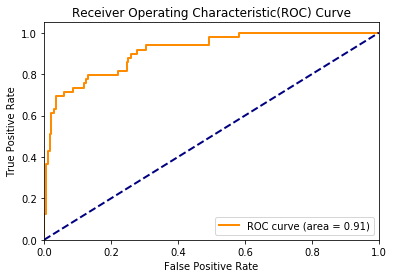

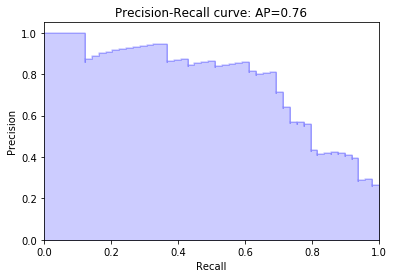

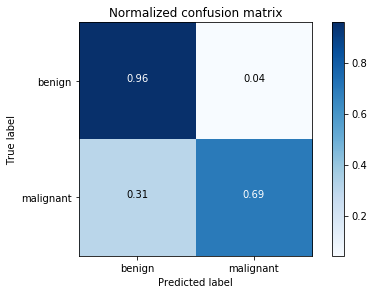

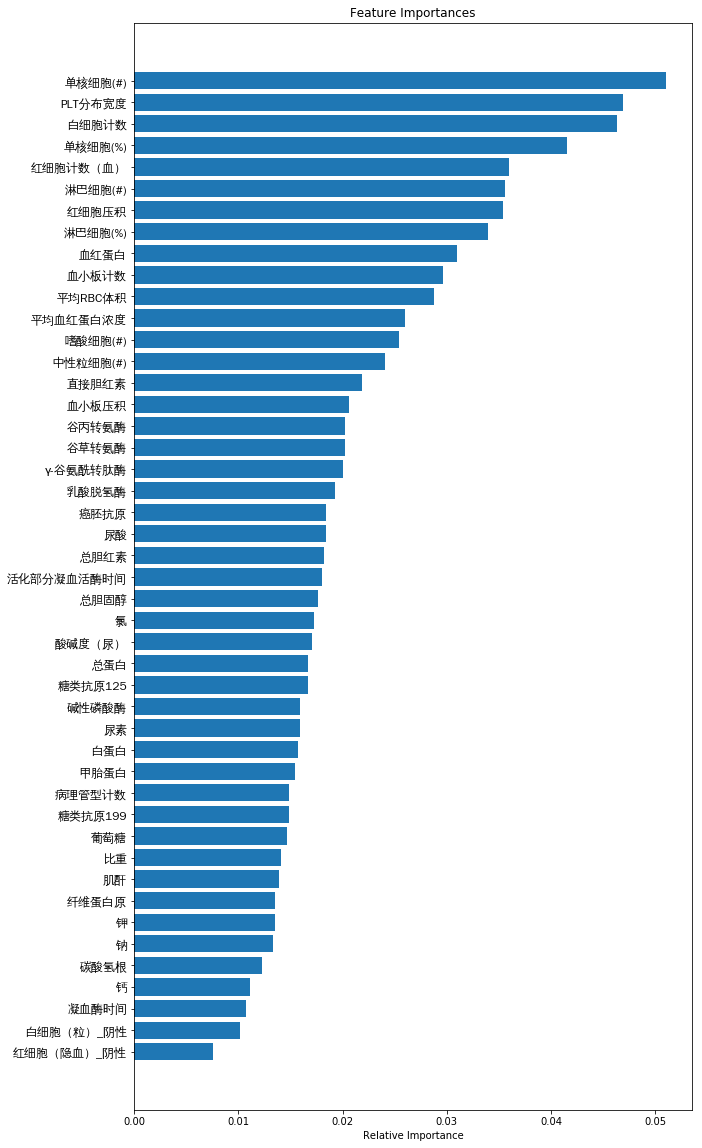

In [43]:
train_x_f_sel, train_y_f_sel, test_x_f_sel,test_y_f_sel,feat_list_f_sel = creat_dataset_with_imp_feature(
    0.6, feat_list_sorted,lab_pos_train,lab_neg_train,lab_pos_test,lab_neg_test)

X_res_f_sel, y_res_f_sel = X_res[:,index_sorted[::-1][:len(feat_list_f_sel)]], y_res
test_x_f_sel, test_y_f_sel = test_x[:,index_sorted[::-1][:len(feat_list_f_sel)]],test_y

best_est_recall.fit(X_res_f_sel, y_res_f_sel)

perf_eval(best_est_recall, test_x_f_sel, test_y_f_sel, cfm_norm=True)
plot_feat_importance(best_est_recall, lab_list, feat_list_f_sel)